# Convert Receipt Image-to-Json using OCR_to_JSON_v1 Model 
> (German Receipt)

#### Experiment
Take an invoice or receipt image, perform OCR on the image to get text boxes, and feed the outputs into LLM models to generate a well-formed receipt JSON object.

#### Motivation
Currently, OCR engines are well tested on image detection and text recognition. LLM models are well trained for text processing and generation. Hence, leveraging outputs from OCR engines could save LLM training times for image-to-text use cases such as invoice or receipt image to JSON object conversion tasks.

#### Process Flow
[Receipt Image] >> [OCR Engine] >> [text boxes] >> [LLM] >> [Json object] 

Take following sample receipt image and get an output Json like this:
<img src="https://asprise.com/ocr/api/img/blog/rcpt/DE-1.jpg" width="250" height="300" alt="Receipt Image in German"/>

```json

{
  "receipt": {
    "receipt_id": "DT1485",
    "receipt_number": "ORD2487-KS.3-",
    "receipt_date": "15.10.2014",
    "receipt_total": "1,19",
    "receipt_total_with_tax": "1,19",
    "receipt_tax": "7,00%",
    "receipt_tax_rate": "0,08",
    "receipt_tax_amount": "0,08",
    "receipt_tax_amount_with_tax": "0,08",
    "receipt_tax_amount_without_tax": "0,08",
    "receipt_tax_amount_with_tax_without_tax": "0,08",
    "receipt_tax_amount_without_tax_with_tax": "0,08",
    "receipt_tax_amount_with_tax_without_tax_with_tax": "0,08",
    "receipt_tax_amount_without_tax_with_tax_without_tax": "0,08",
    "receipt_tax_amount_with_tax_without_tax_with_tax_without_tax": "0,08",
    "receipt_tax_amount_without_tax_with_tax_without_tax_with_tax": "0,08",
    "receipt_tax_amount_with_tax_without_tax_with_tax_without_tax_with_tax": "0,08",
    "receipt_tax_amount_without_tax_with_tax_without_tax_with_tax_without_tax_with_tax": "0,08",
    "receipt_tax_amount_with_tax_without_tax_with_tax_without_tax_with_tax_without_tax_with_tax": "0,08",
    "receipt_tax_amount_without_tax_with_tax_without_tax_with_tax_without_tax_with_tax_without_tax_with_tax": 
"0,08",
    "receipt_tax_amount_with_tax_without_tax_with_tax_without_tax_with_tax_without_tax_with_tax_without_tax_with_ta
x": "0,08",
}
```

In [1]:
import time
t0 = time.time()

In [2]:
import warnings, logging
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

### Environment Preparation

Recommended:
    paddleocr>=2.0.1
    PaddlePaddle >= 2.1.2
    Python 3.7+
    CUDA 10.1+
    cuDNN 7.6+

#### Installation of NVIDIA Cuda + CUDNN
```
wget https://developer.download.nvidia.com/compute/cuda/11.8.0/local_installers/cuda_11.8.0_520.61.05_linux.run
sudo sh cuda_11.8.0_520.61.05_linux.run --toolkit --silent --override

export PATH=/usr/local/cuda-11.8/bin${PATH:+:${PATH}}
export LD_LIBRARY_PATH=/usr/local/cuda-11.8/lib64${LD_LIBRARY_PATH:+:${LD_LIBRARY_PATH}}
source ~/.bashrc


wget https://developer.nvidia.com/compute/cudnn/secure/8.6.0/local_installers/11.8/cudnn-local-repo-ubuntu2004-8.6.0.163_1.0-1_amd64.deb
sudo dpkg -i cudnn-local-repo-ubuntu2004-8.6.0.163_1.0-1_amd64.deb
sudo cp /var/cudnn-local-repo-*/cudnn-local-*-keyring.gpg /usr/share/keyrings/

sudo apt-get update

sudo apt-get install libcudnn8=8.6.0.163-1+cuda11.8
sudo apt-get install libcudnn8-dev=8.6.0.163-1+cuda11.8
sudo apt-get install libcudnn8-samples=8.6.0.163-1+cuda11.8
```

#### Installation of Paddle-GPU  / OCR Engine

```
!python -m pip install paddlepaddle-gpu -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install "paddleocr>=2.0.1"
## if conflict with library version try this fix
##!pip install pillow numpy  
```

> missing cudnn issues: https://github.com/PaddlePaddle/PaddleDetection/issues/7629

In [3]:
!nvidia-smi

Thu Aug  1 17:57:15 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000               Off |   00000000:04:00.0 Off |                  Off |
| 30%   35C    P8              3W /   70W |     113MiB /   6138MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# utility to enhance text display
!pip install rich
from rich import (print, inspect, pretty)
pretty.install()

### 1. Get a Sample Receipt Image

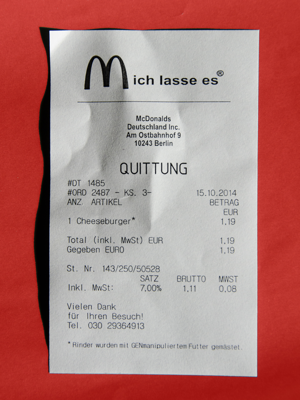

In [5]:
import urllib.request 
import numpy as np
from PIL import Image

# pull a random receipt image from internet
#image_url='https://groups.google.com/group/jzebra-users/attach/d16dbba8a612edfa/Bill%20Image_Receipt.png?part=0.1'
image_url = 'https://asprise.com/ocr/api/img/blog/rcpt/DE-1.jpg'

local_image_id='bill_image_receipt.png'
urllib.request.urlretrieve(image_url,local_image_id) 
receipt_image = Image.open(local_image_id)
receipt_image_array = np.array(receipt_image.convert('RGB'))
display(receipt_image.resize((300,400)))

### 2. OCR Receipt Image

In [6]:
%%time
from paddleocr import PaddleOCR, draw_ocr
from ast import literal_eval
import json

paddleocr = PaddleOCR(lang="en",ocr_version="PP-OCRv4",show_log = False,use_gpu=True)

def paddle_scan(paddleocr,img_path_or_nparray):
    result = paddleocr.ocr(img_path_or_nparray,cls=True)
    result = result[0]
    boxes = [line[0] for line in result]       #boundign box 
    txts = [line[1][0] for line in result]     #raw text
    scores = [line[1][1] for line in result]   # scores
    return  txts, result

# perform ocr scan
receipt_texts, receipt_boxes = paddle_scan(paddleocr,receipt_image_array)
print(50*"--","\ntext only:\n",receipt_texts)
print(50*"--","\nocr boxes:\n",receipt_boxes)

---------------------------------------------------------------------------------------------------- 
text only:

[
    'M',
    '?',
    'ich lasse es',
    'McDonalds',
    'Deutschland Inc.',
    'Am Ostbahnhof 9',
    '10243 Berlin',
    'QUITTUNG',
    '#DT1485',
    '#ORD2487-KS.3-',
    '15.10.2014',
    'ANZ ARTIKEL',
    'BETRAG',
    'EUR',
    '1 Cheeseburger*',
    '1,19',
    'Total(inkl.MwSt) EUR',
    '1.19',
    'Gegeben EURO',
    '1,19',
    'St. Nr.143/250/50528',
    'SATZ',
    'BRUTTO',
    'MWST',
    'Inkl. MwSt:',
    '7,00%',
    '1.11',
    '0,08',
    'Vielen Dank',
    'fur Ihren Besuch!',
    'Tel. 030 29364913',
    '* Rinder wurden mit GENmanipulier tem Futter gemastet'
]

---------------------------------------------------------------------------------------------------- 
ocr boxes:

[
    [[[278.0, 209.0], [424.0, 209.0], [424.0, 353.0], [278.0, 353.0]], ('M', 0.8618687987327576)],
    [[[720.0, 276.0], [745.0, 276.0], [745.0, 299.0], [720.0, 299.0]], ('?', 0.7295060157775879)],
    [[[440.0, 289.0], [732.0, 294.0], [731.0, 341.0], [439.0, 335.0]], ('ich lasse es', 0.9927904605865479)],
    [[[452.0, 452.0], [572.0, 452.0], [572.0, 482.0], [452.0, 482.0]], ('McDonalds', 0.995570719242096)],
    [[[423.0, 483.0], [599.0, 487.0], [598.0, 516.0], [422.0, 513.0]], ('Deutschland Inc.', 0.9738422632217407)],
    [[[419.0, 518.0], [605.0, 518.0], [605.0, 546.0], [419.0, 546.0]], ('Am Ostbahnhof 9', 0.950401246547699)],
    [[[446.0, 544.0], [579.0, 548.0], [578.0, 582.0], [445.0, 578.0]], ('10243 Berlin', 0.9703571796417236)],
    [[[399.0, 634.0], [627.0, 638.0], [626.0, 691.0], [398.0, 687.0]], ('QUITTUNG', 0.9944849014282227)],
    [[[225.0, 707.0], [350.0, 707.0], [350.0, 736.0], [225.0, 736.0]], ('#DT1485', 0.977080762386322)],
    [[[224.0, 743.0], [503.0, 743.0], [503.0, 776.0], [224.0, 776.0]], ('#ORD2487-KS.3-', 0.9446905851364136)],
    [[[655.0, 745.0], [791.0, 745.0], [791.0, 774.0], [655.0, 774.0]], ('15.10.2014', 0.9962570071220398)],
    [[[224.0, 779.0], [405.0, 779.0], [405.0, 812.0], [224.0, 812.0]], ('ANZ ARTIKEL', 0.9452850222587585)],
    [[[696.0, 781.0], [801.0, 781.0], [801.0, 815.0], [696.0, 815.0]], ('BETRAG', 0.996555745601654)],
    [[[742.0, 819.0], [796.0, 819.0], [796.0, 851.0], [742.0, 851.0]], ('EUR', 0.9969186782836914)],
    [[[224.0, 853.0], [451.0, 853.0], [451.0, 888.0], [224.0, 888.0]], ('1 Cheeseburger*', 0.9660457372665405)],
    [[[732.0, 855.0], [791.0, 855.0], [791.0, 893.0], [732.0, 893.0]], ('1,19', 0.9598152041435242)],
    [
        [[224.0, 932.0], [543.0, 932.0], [543.0, 960.0], [224.0, 960.0]],
        ('Total(inkl.MwSt) EUR', 0.9012374877929688)
    ],
    [[[729.0, 932.0], [785.0, 932.0], [785.0, 965.0], [729.0, 965.0]], ('1.19', 0.9903130531311035)],
    [[[222.0, 968.0], [416.0, 968.0], [416.0, 1001.0], [222.0, 1001.0]], ('Gegeben EURO', 0.9684236645698547)],
    [[[727.0, 968.0], [788.0, 968.0], [788.0, 1006.0], [727.0, 1006.0]], ('1,19', 0.9600515365600586)],
    [
        [[221.0, 1042.0], [533.0, 1044.0], [533.0, 1073.0], [220.0, 1072.0]],
        ('St. Nr.143/250/50528', 0.9668201208114624)
    ],
    [[[462.0, 1080.0], [533.0, 1080.0], [533.0, 1116.0], [462.0, 1116.0]], ('SATZ', 0.997729480266571)],
    [[[586.0, 1080.0], [688.0, 1080.0], [688.0, 1114.0], [586.0, 1114.0]], ('BRUTTO', 0.9949141144752502)],
    [[[725.0, 1082.0], [796.0, 1082.0], [796.0, 1118.0], [725.0, 1118.0]], ('MWST', 0.9961545467376709)],
    [[[224.0, 1116.0], [380.0, 1116.0], [380.0, 1151.0], [224.0, 1151.0]], ('Inkl. MwSt:', 0.8678375482559204)],
    [[[464.0, 1114.0], [542.0, 1118.0], [540.0, 1156.0], [462.0, 1152.0]], ('7,00%', 0.9523078799247742)],
    [[[604.0, 1119.0], [661.0, 1119.0], [661.0, 1157.0], [604.0, 1157.0]], ('1.11', 0.8894205689430237)],
    [[[725.0, 1121.0], [793.0, 1121.0], [793.0, 1157.0], [725.0, 1157.0]], ('0,08', 0.9447673559188843)],
    [[[222.0, 1192.0], [388.0, 1192.0], [388.0, 1225.0], [222.0, 1225.0]], ('Vielen Dank', 0.9775956869125366)],
    [
        [[222.0, 1228.0], [479.0, 1231.0], [478.0, 1264.0], [222.0, 1261.0]],
        ('fur Ihren Besuch!', 0.939074695110321)
    ],
    [
        [[224.0, 1267.0], [480.0, 1271.0], [480.0, 1299.0], [224.0, 1295.0]],
        ('Tel. 030 29364913', 0.9304860234260559)
    ],
    [
        [[224.0, 1343.0], [803.0, 1356.0], [802.0, 1386.0], [223.0, 1372.0]],
        ('* Rinder wurden mit GENmanipulier tem Futter gemastet', 0.9827935099601746)
    ]
]

CPU times: user 2.48 s, sys: 859 ms, total: 3.34 s
Wall time: 3.33 s


### 3. Load Finetuned LLM Model

In [7]:
%%time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, BitsAndBytesConfig

# quantization_config = BitsAndBytesConfig(llm_int8_enable_fp32_cpu_offload=True)
bnb_config = BitsAndBytesConfig(
    llm_int8_enable_fp32_cpu_offload=True,
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
# control model memory allocation between devices for low GPU resource (0,cpu)
device_map = {
    "transformer.word_embeddings": 0,
    "transformer.word_embeddings_layernorm": 0,
    "lm_head": 0,
    "transformer.h": 0,
    "transformer.ln_f": 0,
    "model.embed_tokens": 0,
    "model.layers":0,
    "model.norm":0    
}
device = "cuda" if torch.cuda.is_available() else "cpu"

# model use for inference
model_id="mychen76/mistral7b_ocr_to_json_v1"
model = AutoModelForCausalLM.from_pretrained(
    model_id, 
    trust_remote_code=True,  
    torch_dtype=torch.float16,
    quantization_config=bnb_config,
    device_map=device_map)
# tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 6.4 s, sys: 7.16 s, total: 13.6 s
Wall time: 13.8 s


In [8]:
model.config


MistralConfig {
  "_name_or_path": "mychen76/mistral7b_ocr_to_json_v1",
  "architectures": [
    "MistralForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": true,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "rope_theta": 10000.0,
  "sliding_window": 409

### 4. Run Inference

In [9]:
prompt=f"""### Instruction:
You are POS receipt data expert, parse, detect, recognize and convert following receipt OCR image result into structure receipt data object. 
Don't make up value not in the Input. Output must be a well-formed JSON object.```json

### Input:
{receipt_boxes}

### Output:
"""

In [10]:
%%time
with torch.inference_mode():
    inputs = tokenizer(prompt,return_tensors="pt",truncation=True).to(device)
    outputs = model.generate(**inputs, max_new_tokens=872,temperature=1,top_p=0.95) ##use_cache=True, do_sample=True,temperature=0.1, top_p=0.95
    result_text = tokenizer.batch_decode(outputs)[0]
    print(result_text)

# clear 
torch.cuda.empty_cache()

<s> ### Instruction:
You are POS receipt data expert, parse, detect, recognize and convert following receipt OCR image result into 
structure receipt data object. 
Don't make up value not in the Input. Output must be a well-formed JSON object.```json

### Input:
[[[[278.0, 209.0], [424.0, 209.0], [424.0, 353.0], [278.0, 353.0]], ('M', 0.8618687987327576)], [[[720.0, 276.0], 
[745.0, 276.0], [745.0, 299.0], [720.0, 299.0]], ('?', 0.7295060157775879)], [[[440.0, 289.0], [732.0, 294.0], 
[731.0, 341.0], [439.0, 335.0]], ('ich lasse es', 0.9927904605865479)], [[[452.0, 452.0], [572.0, 452.0], [572.0, 
482.0], [452.0, 482.0]], ('McDonalds', 0.995570719242096)], [[[423.0, 483.0], [599.0, 487.0], [598.0, 516.0], 
[422.0, 513.0]], ('Deutschland Inc.', 0.9738422632217407)], [[[419.0, 518.0], [605.0, 518.0], [605.0, 546.0], 
[419.0, 546.0]], ('Am Ostbahnhof 9', 0.950401246547699)], [[[446.0, 544.0], [579.0, 548.0], [578.0, 582.0], [445.0,
578.0]], ('10243 Berlin', 0.9703571796417236)], [[[399.0, 634.0], [627.0, 638.0], [626.0, 691.0], [398.0, 687.0]], 
('QUITTUNG', 0.9944849014282227)], [[[225.0, 707.0], [350.0, 707.0], [350.0, 736.0], [225.0, 736.0]], ('#DT1485', 
0.977080762386322)], [[[224.0, 743.0], [503.0, 743.0], [503.0, 776.0], [224.0, 776.0]], ('#ORD2487-KS.3-', 
0.9446905851364136)], [[[655.0, 745.0], [791.0, 745.0], [791.0, 774.0], [655.0, 774.0]], ('15.10.2014', 
0.9962570071220398)], [[[224.0, 779.0], [405.0, 779.0], [405.0, 812.0], [224.0, 812.0]], ('ANZ ARTIKEL', 
0.9452850222587585)], [[[696.0, 781.0], [801.0, 781.0], [801.0, 815.0], [696.0, 815.0]], ('BETRAG', 
0.996555745601654)], [[[742.0, 819.0], [796.0, 819.0], [796.0, 851.0], [742.0, 851.0]], ('EUR', 
0.9969186782836914)], [[[224.0, 853.0], [451.0, 853.0], [451.0, 888.0], [224.0, 888.0]], ('1 Cheeseburger*', 
0.9660457372665405)], [[[732.0, 855.0], [791.0, 855.0], [791.0, 893.0], [732.0, 893.0]], ('1,19', 
0.9598152041435242)], [[[224.0, 932.0], [543.0, 932.0], [543.0, 960.0], [224.0, 960.0]], ('Total(inkl.MwSt) EUR', 
0.9012374877929688)], [[[729.0, 932.0], [785.0, 932.0], [785.0, 965.0], [729.0, 965.0]], ('1.19', 
0.9903130531311035)], [[[222.0, 968.0], [416.0, 968.0], [416.0, 1001.0], [222.0, 1001.0]], ('Gegeben EURO', 
0.9684236645698547)], [[[727.0, 968.0], [788.0, 968.0], [788.0, 1006.0], [727.0, 1006.0]], ('1,19', 
0.9600515365600586)], [[[221.0, 1042.0], [533.0, 1044.0], [533.0, 1073.0], [220.0, 1072.0]], ('St. 
Nr.143/250/50528', 0.9668201208114624)], [[[462.0, 1080.0], [533.0, 1080.0], [533.0, 1116.0], [462.0, 1116.0]], 
('SATZ', 0.997729480266571)], [[[586.0, 1080.0], [688.0, 1080.0], [688.0, 1114.0], [586.0, 1114.0]], ('BRUTTO', 
0.9949141144752502)], [[[725.0, 1082.0], [796.0, 1082.0], [796.0, 1118.0], [725.0, 1118.0]], ('MWST', 
0.9961545467376709)], [[[224.0, 1116.0], [380.0, 1116.0], [380.0, 1151.0], [224.0, 1151.0]], ('Inkl. MwSt:', 
0.8678375482559204)], [[[464.0, 1114.0], [542.0, 1118.0], [540.0, 1156.0], [462.0, 1152.0]], ('7,00%', 
0.9523078799247742)], [[[604.0, 1119.0], [661.0, 1119.0], [661.0, 1157.0], [604.0, 1157.0]], ('1.11', 
0.8894205689430237)], [[[725.0, 1121.0], [793.0, 1121.0], [793.0, 1157.0], [725.0, 1157.0]], ('0,08', 
0.9447673559188843)], [[[222.0, 1192.0], [388.0, 1192.0], [388.0, 1225.0], [222.0, 1225.0]], ('Vielen Dank', 
0.9775956869125366)], [[[222.0, 1228.0], [479.0, 1231.0], [478.0, 1264.0], [222.0, 1261.0]], ('fur Ihren Besuch!', 
0.939074695110321)], [[[224.0, 1267.0], [480.0, 1271.0], [480.0, 1299.0], [224.0, 1295.0]], ('Tel. 030 29364913', 
0.9304860234260559)], [[[224.0, 1343.0], [803.0, 1356.0], [802.0, 1386.0], [223.0, 1372.0]], ('* Rinder wurden mit 
GENmanipulier tem Futter gemastet', 0.9827935099601746)]]

### Output:
```json
{
  "receipt": {
    "receipt_id": "DT1485",
    "receipt_number": "ORD2487-KS.3-",
    "receipt_date": "15.10.2014",
    "receipt_total": "1,19",
    "receipt_total_with_tax": "1,19",
    "receipt_tax": "7,00%",
    "receipt_tax_rate": "0,08",
    "receipt_tax_amount": "0,08",
    "receipt

CPU times: user 33.6 s, sys: 535 ms, total: 34.2 s
Wall time: 34.1 s


In [11]:
#result_text

### 5. View Result Json Object

In [12]:
import json
output_text = result_text.split("json")[2]
output_text = output_text.replace("```","")
output_text = output_text.split("### Hints")
if len(output_text)>1:
    output_json=output_text[0]
else:
    output_json = output_text

## load out as json object
json.loads(output_json)

TypeError: the JSON object must be str, bytes or bytearray, not list

In [ ]:
t1 = time.time()
total_time = t1-t0
print("took ",total_time)